In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
torch.manual_seed(42)

###############################################
# Explanation:
# We will use a simple thermometer calibration example.
# Our goal is to learn a linear mapping from unknown units (t_u) to Celsius (t_c)
# using the model: t_c = w * t_u + b.
# We'll explore:
#  - Manual gradient descent with autograd.
#  - Using PyTorch optimizers (SGD, Adam) to update parameters.
###############################################


In [2]:
# Temperature in Celsius (t_c) and thermometer readings in unknown units (t_u)
t_c_list = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u_list = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# Convert the lists to PyTorch tensors of type float
t_c = torch.tensor(t_c_list, dtype=torch.float)
t_u = torch.tensor(t_u_list, dtype=torch.float)

###############################################
# Expected Output:
# t_c and t_u are now 1D tensors of shape [11].
###############################################


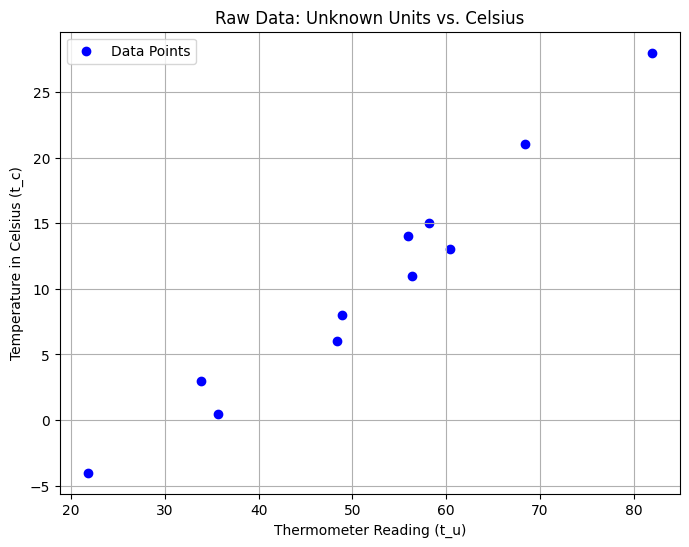

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(t_u.numpy(), t_c.numpy(), color='blue', label='Data Points')
plt.xlabel("Thermometer Reading (t_u)")
plt.ylabel("Temperature in Celsius (t_c)")
plt.title("Raw Data: Unknown Units vs. Celsius")
plt.legend()
plt.grid(True)
plt.show()

###############################################
# Explanation:
# This scatter plot shows the raw data. We expect a linear relationship.
###############################################


In [4]:
def model(t_u, w, b):
    """
    Linear model: t_c_pred = w * t_u + b
    """
    return w * t_u + b

def loss_fn(t_p, t_c):
    """
    Mean Squared Error (MSE) loss: average((t_p - t_c)^2)
    """
    return ((t_p - t_c) ** 2).mean()

###############################################
# Explanation:
# These functions define our model and the loss.
# Our objective is to minimize the loss by adjusting w and b.
###############################################


In [5]:
# Initialize parameters with requires_grad=True so that PyTorch tracks all operations.
params = torch.tensor([1.0, 0.0], dtype=torch.float, requires_grad=True)

# Compute the model's prediction and the loss
t_p = model(t_u, params[0], params[1])
loss = loss_fn(t_p, t_c)

# Compute gradients via backpropagation
loss.backward()

print("Loss:", loss.item())
print("Gradient for [w, b]:", params.grad)

###############################################
# Expected Output:
# You should see a loss value and a tensor containing gradients for w and b.
# The gradients are automatically computed by PyTorch.
###############################################


Loss: 1763.884765625
Gradient for [w, b]: tensor([4517.2969,   82.6000])


In [15]:
def training_loop_manual(n_epochs, learning_rate, params, t_u, t_c):
    """
    Train the model using manual gradient descent.
    This loop performs:
      - Forward pass: compute predictions and loss.
      - Backward pass: compute gradients.
      - Parameter update: update params manually and detach to reset the computation graph.
    """
    losses = []
    for epoch in range(1, n_epochs + 1):
        # Forward pass
        t_p = model(t_u, params[0], params[1])
        loss = loss_fn(t_p, t_c)
        losses.append(loss.item())
        
        # Zero gradients (if any)
        if params.grad is not None:
            params.grad.zero_()
        
        # Backward pass: compute gradients automatically
        loss.backward()
        
        # Manual parameter update and detach from the current graph
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        # Re-enable gradient tracking for updated parameters
        params.requires_grad_()
        
        # Logging every 500 epochs for brevity
        if epoch % 500 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d}, Loss: {loss.item():.6f}, Params: {params.detach().numpy()}")
    
    return params, losses

# Use a smaller learning rate to avoid divergence
print("=== Training with Manual Gradient Descent (Autograd) ===")
params_init = torch.tensor([1.0, 0.0], dtype=torch.float, requires_grad=True)
n_epochs_manual = 5000
learning_rate_manual = 1e-5

trained_params_manual, losses_manual = training_loop_manual(
    n_epochs=n_epochs_manual,
    learning_rate=learning_rate_manual,
    params=params_init,
    t_u=t_u,
    t_c=t_c
)


=== Training with Manual Gradient Descent (Autograd) ===
Epoch    1, Loss: 1763.884766, Params: [ 9.5482701e-01 -8.2599994e-04]
Epoch  500, Loss: 29.067583, Params: [ 0.23245661 -0.02865738]
Epoch 1000, Loss: 29.021849, Params: [ 0.23272292 -0.04377671]
Epoch 1500, Loss: 28.976196, Params: [ 0.23298901 -0.05888282]
Epoch 2000, Loss: 28.930622, Params: [ 0.23325485 -0.07397565]
Epoch 2500, Loss: 28.885126, Params: [ 0.23352048 -0.08905528]
Epoch 3000, Loss: 28.839714, Params: [ 0.23378587 -0.10412183]
Epoch 3500, Loss: 28.794374, Params: [ 0.23405102 -0.11917502]
Epoch 4000, Loss: 28.749126, Params: [ 0.23431593 -0.13421524]
Epoch 4500, Loss: 28.703949, Params: [ 0.23458062 -0.14924206]
Epoch 5000, Loss: 28.658852, Params: [ 0.23484509 -0.16425596]


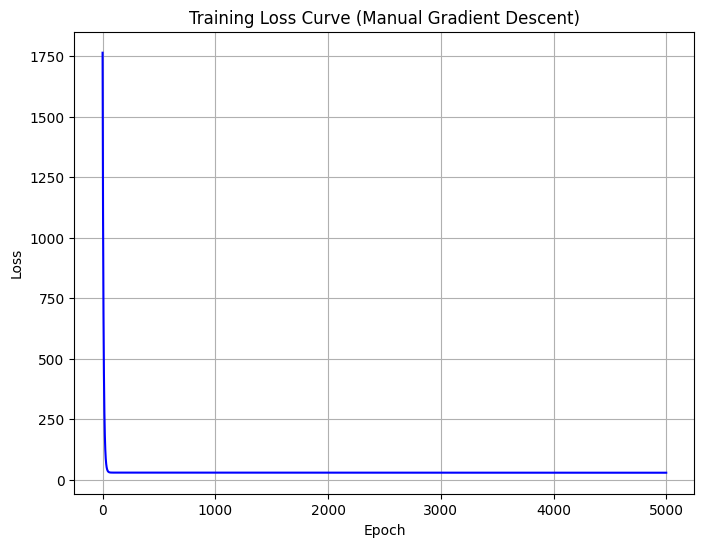

In [16]:
plt.figure(figsize=(8,6))
plt.plot(losses_manual, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Manual Gradient Descent)")
plt.grid(True)
plt.show()

###############################################
# Explanation:
# The loss should gradually decrease over epochs.
# If the loss plateaus or becomes unstable (diverges), you may need to adjust the learning rate.
###############################################


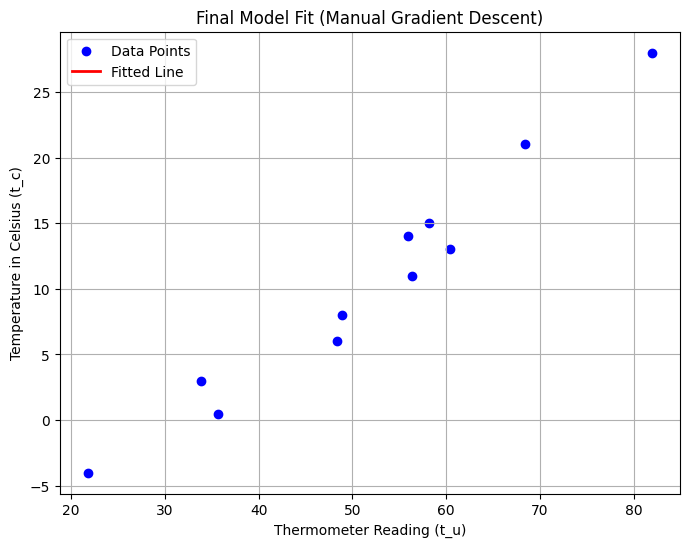

In [8]:
t_p_final_manual = model(t_u, trained_params_manual[0], trained_params_manual[1])
plt.figure(figsize=(8,6))
plt.scatter(t_u.numpy(), t_c.numpy(), color='blue', label="Data Points")
plt.plot(t_u.numpy(), t_p_final_manual.detach().numpy(), color='red', linewidth=2, label="Fitted Line")
plt.xlabel("Thermometer Reading (t_u)")
plt.ylabel("Temperature in Celsius (t_c)")
plt.title("Final Model Fit (Manual Gradient Descent)")
plt.legend()
plt.grid(True)
plt.show()

###############################################
# Expected Output:
# The red line should closely fit the blue data points, indicating that our model
# has learned a good approximation of the conversion from t_u to t_c.
###############################################


In [9]:
def training_loop_optim(n_epochs, optimizer, params, t_u, t_c):
    """
    Train the model using a PyTorch optimizer.
    This loop leverages the optimizer's zero_grad() and step() methods to update parameters.
    """
    losses = []
    for epoch in range(1, n_epochs + 1):
        # Forward pass: compute predictions and loss
        t_p = model(t_u, params[0], params[1])
        loss = loss_fn(t_p, t_c)
        losses.append(loss.item())
        
        # Zero the gradients before the backward pass
        optimizer.zero_grad()
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update parameters using the optimizer
        optimizer.step()
        
        # Log every 500 epochs
        if epoch % 500 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d}, Loss: {loss.item():.6f}")
    
    return params, losses

# Reset parameters for optimizer training (ensure they have requires_grad=True)
params_optim = torch.tensor([1.0, 0.0], dtype=torch.float, requires_grad=True)

# Use the normalized input if desired; here we use the original t_u
n_epochs_optim = 5000
learning_rate_optim = 1e-2

# Instantiate an SGD optimizer to update our parameters
optimizer = optim.SGD([params_optim], lr=learning_rate_optim)

print("=== Training with torch.optim.SGD ===")
trained_params_optim, losses_optim = training_loop_optim(
    n_epochs=n_epochs_optim,
    optimizer=optimizer,
    params=params_optim,
    t_u=t_u,   # Using original t_u; try normalizing if necessary.
    t_c=t_c
)


=== Training with torch.optim.SGD ===
Epoch    1, Loss: 1763.884766
Epoch  500, Loss: nan
Epoch 1000, Loss: nan
Epoch 1500, Loss: nan
Epoch 2000, Loss: nan
Epoch 2500, Loss: nan
Epoch 3000, Loss: nan
Epoch 3500, Loss: nan
Epoch 4000, Loss: nan
Epoch 4500, Loss: nan
Epoch 5000, Loss: nan


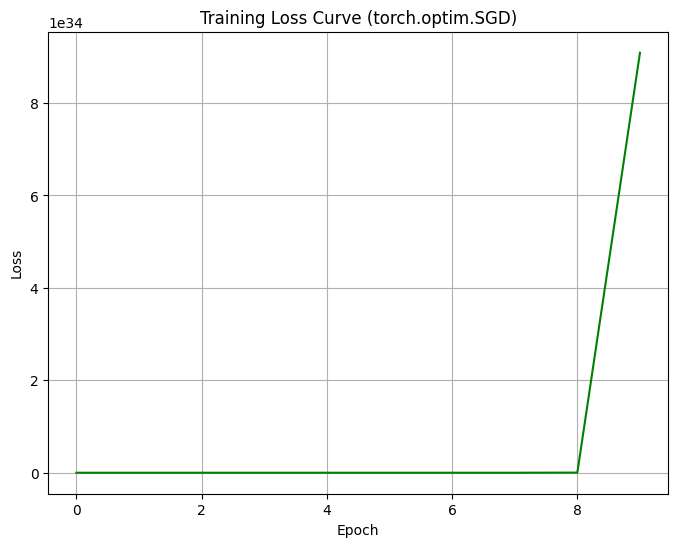

In [10]:
plt.figure(figsize=(8,6))
plt.plot(losses_optim, color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (torch.optim.SGD)")
plt.grid(True)
plt.show()


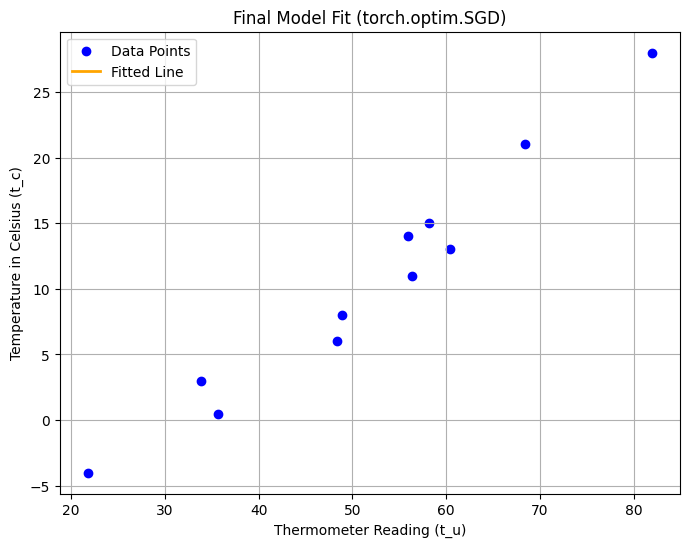

In [11]:
t_p_final_optim = model(t_u, trained_params_optim[0], trained_params_optim[1])
plt.figure(figsize=(8,6))
plt.scatter(t_u.numpy(), t_c.numpy(), color='blue', label="Data Points")
plt.plot(t_u.numpy(), t_p_final_optim.detach().numpy(), color='orange', linewidth=2, label="Fitted Line")
plt.xlabel("Thermometer Reading (t_u)")
plt.ylabel("Temperature in Celsius (t_c)")
plt.title("Final Model Fit (torch.optim.SGD)")
plt.legend()
plt.grid(True)
plt.show()

###############################################
# Explanation:
# Both training methods (manual updates with autograd and using torch.optim.SGD)
# should yield similar final parameters that convert t_u to t_c.
# Additionally, the loss curves provide insight into the training dynamics.
###############################################


=== Training with torch.optim.Adam ===
Epoch    1, Loss: 1763.884766
Epoch  500, Loss: 7.612900
Epoch 1000, Loss: 3.086698
Epoch 1500, Loss: 2.928578
Epoch 2000, Loss: 2.927646


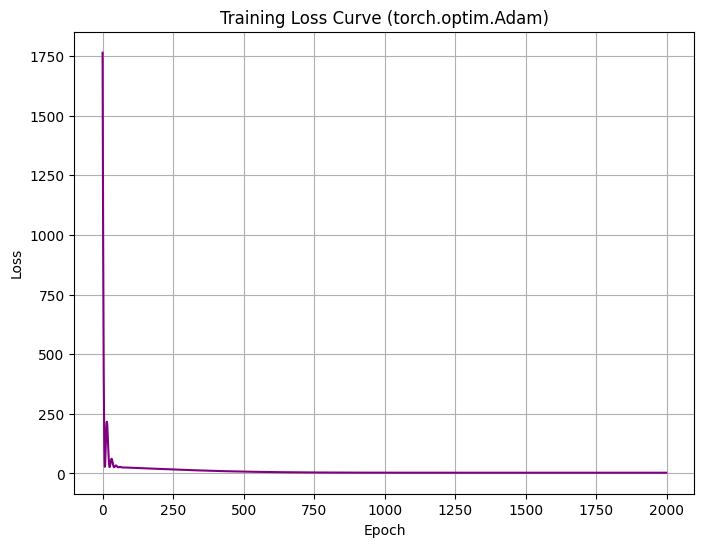

Trained parameters with Adam: [  0.5367238 -17.30206  ]


In [12]:
# Adam is an adaptive optimizer that often converges faster and is less sensitive to learning rates.
params_adam = torch.tensor([1.0, 0.0], dtype=torch.float, requires_grad=True)
learning_rate_adam = 1e-1  # Adam is generally less sensitive, so we can use a higher learning rate
optimizer_adam = optim.Adam([params_adam], lr=learning_rate_adam)

print("=== Training with torch.optim.Adam ===")
trained_params_adam, losses_adam = training_loop_optim(
    n_epochs=2000,
    optimizer=optimizer_adam,
    params=params_adam,
    t_u=t_u,   # Using original t_u
    t_c=t_c
)

plt.figure(figsize=(8,6))
plt.plot(losses_adam, color='purple')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (torch.optim.Adam)")
plt.grid(True)
plt.show()

print("Trained parameters with Adam:", trained_params_adam.detach().numpy())

###############################################
# Final Explanation:
# This tutorial demonstrated:
#  - How to prepare and visualize data.
#  - Defining a linear model and MSE loss.
#  - Using autograd to compute gradients automatically.
#  - Manually updating parameters using autograd.
#  - Leveraging PyTorch's optimizers (SGD and Adam) for parameter updates.
#  - Plotting loss curves and the final model fit.
#
# These are the building blocks of learning in PyTorch. With this knowledge, you're
# ready to build and train more complex models!
###############################################